# PPO, R-PPO and VAE comparison
## PPO runs

In [ ]:
from runner import Runner
from plots import Experiment
from parameters import Parameters, PPOParameters, CardSimParameters, ClassificationParameters

params = Parameters(
    agent=PPOParameters.best_ppo(),
    cardsim=CardSimParameters.paper_params(),
    clf_params=ClassificationParameters.paper_params(),
    seed_value=18,
    logdir="logs/ppo-paper"
)
exp = Experiment.create(params)
for p in params.repeat(12):
    runner = Runner(params)
    episodes = runner.run()
    exp.add(episodes, p.seed_value)


2023-10-02 avg score=59.99 - total=161324.01:  75%|███████▍  | 2988/4000 [02:00<00:18, 55.21it/s] 

## VAE runs

In [ ]:
from runner import Runner
from plots import Experiment
from parameters import Parameters, VAEParameters, CardSimParameters, ClassificationParameters

params = Parameters(
    agent=VAEParameters.best_vae(),
    cardsim=CardSimParameters.paper_params(),
    clf_params=ClassificationParameters.paper_params(),
    seed_value=0,
    logdir="logs/vae-paper",
)

exp = Experiment.create(params)
for p in params.repeat(30):
    runner = Runner(params)
    episodes = runner.run()
    exp.add(episodes, p.seed_value)


## R-PPO runs

In [ ]:
from runner import Runner
from plots import Experiment
from parameters import Parameters, PPOParameters, CardSimParameters, ClassificationParameters

params = Parameters(
    agent=PPOParameters.best_rppo(),
    cardsim=CardSimParameters.paper_params(),
    clf_params=ClassificationParameters.paper_params(),
    seed_value=0,
    logdir="logs/rppo-paper",
)

exp = Experiment.create(params)
for p in params.repeat(30):
    runner = Runner(params)
    episodes = runner.run()
    exp.add(episodes, p.seed_value)


## Score over training time

tuning/vae/trial-14/params.json
tuning/r-ppo/trial-88/params.json


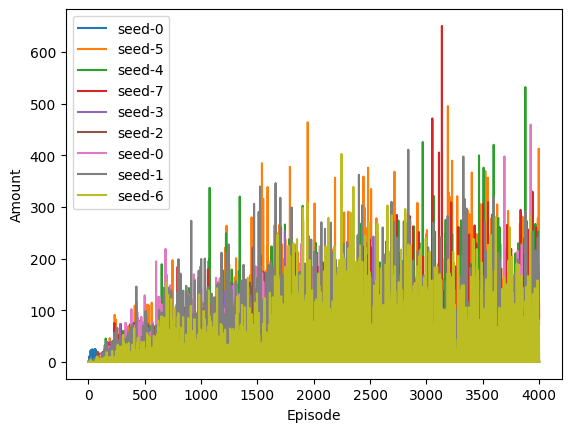

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from plots import Experiment

logdirs = {
    "ppo": "logs/ppo-paper",
    # "vae": "logs/vae-paper",
}

for label, logdir in logdirs.items():
    exp = Experiment.load(logdir)
    mean, std = exp.mean_std_amounts_over_time
    # Compute the 95% confidence interval from the STD
    ci95 = 1.96 * (std / np.sqrt(exp.n_runs))
    plt.plot(mean, label=label)
    plt.fill_between(range(len(mean)), mean - ci95, mean + ci95, alpha=0.2)

plt.xlabel("Episode")
plt.ylabel("Amount")
plt.legend()



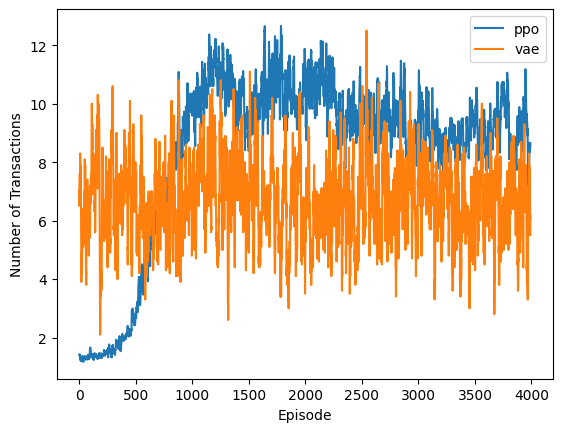

In [ ]:
for label, logdir in logdirs.items():
    exp = Experiment.load(logdir)

    mean = np.mean(exp.n_transactions_over_time, axis=0)
    mean = moving_average(mean, 10)
    plt.plot(mean, label=label)
    # plt.fill_between(range(len(mean)), mean - ci95, mean + ci95, alpha=0.2)
plt.xlabel("Episode")
plt.ylabel("Number of Transactions")
plt.legend()


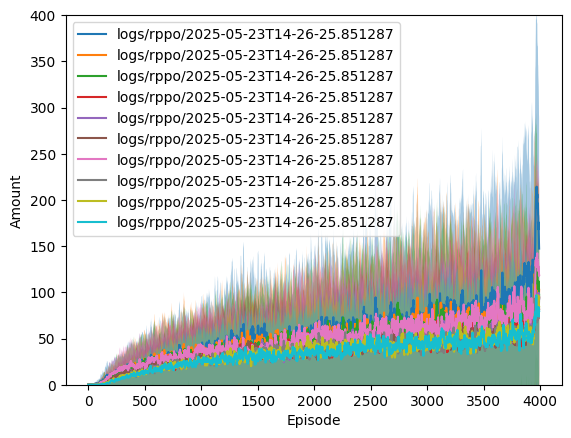

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from plots import Experiment
import os
from environment.priority_queue import PriorityQueue

prefix = os.path.join("logs", "rppo")
logdirs = os.listdir(prefix)
# logdirs = ["2025-05-23T00-47-38.363831/"]


def moving_average(x, w=10):
    return np.convolve(x, np.ones(w), "valid") / w


total = PriorityQueue[Experiment]()

for logdir in logdirs:
    logdir = os.path.join(prefix, logdir)
    exp = Experiment.load(logdir)
    if exp is None:
        continue
    total.push(exp, -exp.total_amount)
    # print(logs.amounts_over_time.shape)
    #

for i in range(10):
    exp = total.pop()
    mean = np.mean(exp.amounts_over_time, axis=0)
    mean = moving_average(mean, 10)
    std = np.std(exp.amounts_over_time, axis=0)
    std = moving_average(std, 10)
    plt.plot(mean, label=exp.logdir)
    plt.fill_between(range(len(mean)), mean - std, mean + std, alpha=0.4)
plt.xlabel("Episode")
plt.ylabel("Amount")
plt.ylim(0, 400)
plt.legend()
